In [122]:
# -*- coding: utf-8 -*-
%matplotlib inline
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set(style="ticks")

In [123]:
# Read recipe inputs
transactions_known_scored = dataiku.Dataset("transactions_known_scored").get_dataframe()

In [124]:
list_var = ['authorized_flag','proba_1']
transactions_known_scored = transactions_known_scored[list_var]
transactions_known_scored['decile'] = pd.cut(x=transactions_known_scored.proba_1,
                                             bins=10, precision=1, right=False)
transactions_known_scored.decile = transactions_known_scored.decile.astype(str)

In [125]:
col_names = {'authorized_flag':'sum_true', 'proba_1':'count_pred'}
df_by_deciles = transactions_known_scored.groupby(by='decile').agg({'authorized_flag':'sum',
                                                                    'proba_1':'count'}).rename(columns=col_names)

In [126]:
df_by_deciles['validation_ratio'] = df_by_deciles.sum_true/df_by_deciles.count_pred
df_by_deciles.sort_index(ascending=True, inplace=True)

In [127]:
df_by_deciles.head()

,sum_true,count_pred,validation_ratio
decile,,,
"[0.02, 0.1)",46,225,0.204444
"[0.1, 0.2)",57,281,0.202847
"[0.2, 0.3)",713,1671,0.426691
"[0.3, 0.4)",8066,11490,0.702002
"[0.4, 0.5)",32283,36433,0.886092


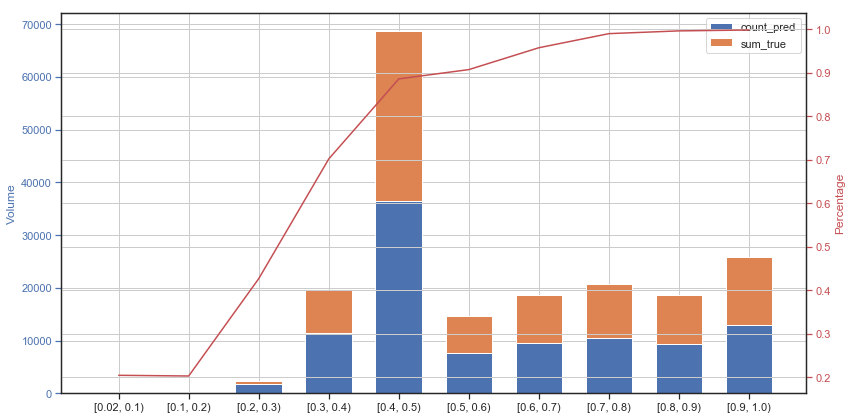

In [136]:
labels = list(df_by_deciles.index)
sum_true = list(df_by_deciles.sum_true)
count_pred = list(df_by_deciles.count_pred)
validation_ratio = list(df_by_deciles.validation_ratio)
width = 2/3 # the width of the bars

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(labels, count_pred, width, label='count_pred')
ax1.bar(labels, sum_true, width, bottom=count_pred, label='sum_true')
color = 'b'
ax1.set_ylabel('Volume', color=color)
ax1.tick_params('y', colors=color)
ax1.legend()
plt.grid()

ax2 = ax1.twinx()
color = 'r'
ax2.plot(labels, validation_ratio, color=color)
ax2.set_ylabel('Percentage', color=color)
ax2.tick_params('y', colors=color)
plt.grid()

#plt.title('Real vs predicted observations by decile (on the test set)')
fig.tight_layout()
plt.show()

In [130]:
# Save plot to folder
folder_for_plot = dataiku.Folder("ofSVU3Pe")
folder_path = folder_for_plot.get_path()

path_fig = os.path.join(folder_path, "output.png")
plt.savefig(path_fig)

<Figure size 432x288 with 0 Axes>